In [4]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from chat_downloader import ChatDownloader
from wordcloud import WordCloud
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
import math
import json

from matplotlib.ticker import MultipleLocator

from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.pdfbase.ttfonts import TTFont
from reportlab.pdfbase import pdfmetrics
from reportlab.lib.utils import ImageReader

%matplotlib inline

In [5]:
def title_convert_to_array(title_string):
    match = re.match(r'(.*) \((\d+) (year|years|month|months)\)', title_string)

    if match:
        name = match.group(1)
        number = int(match.group(2))
        period = match.group(3)

        if period in ('year', 'years'):
            days = number * 365
        elif period in ('month', 'months'):
            days = number * 30

        return (name, days)
    else:
        return ('', 0)


def minutes_to_hhmm(minutes):
    hours = int(minutes // 60)
    mins = int(minutes % 60)
    return f'{hours:02d}:{mins:02d}'


def recursive_replace(pattern, replacement, text):
    regex = re.compile(pattern)
    previous_text = None

    while previous_text != text:
        previous_text = text
        text = regex.sub(replacement, text)

    return text.strip() if text else ''


def logging_watching_url(output_path, url, time, file_name: str = 'watching_urls.log'):
    path = os.path.join(output_path, file_name)
    with open(path, 'a', encoding='utf8') as f:
        f.write(url + f'?t={time}\n')


def get_word_freq(array):
    text_vectorizer = CountVectorizer(stop_words='english', encoding='utf8')
    X = text_vectorizer.fit_transform(array)
    word_freq = pd.DataFrame(
        X.toarray(), columns=text_vectorizer.get_feature_names_out())
    word_freq = word_freq.sum().sort_values(ascending=False)
    return word_freq


def draw_markdown_to_pdf(canvas, text, cursor, margin, width, height, font_name):
    # 轉換 Markdown 到純文本
    paragraphs = text.split('\n')

    canvas.setFont(font_name, 8)
    for paragraph in paragraphs:
        lines = paragraph.split('\n')
        for line in lines:
            # 計算每一行文本的寬度並進行多行處理
            if cursor < 50:  # 確保不超出頁面底部
                canvas.showPage()
                cursor = height - 50
            text_width = canvas.stringWidth(line, font_name, 12)
            if text_width > width:
                # 如果行寬超出可用寬度，進行換行處理
                words = line.split(' ')
                current_line = ""
                for word in words:
                    if canvas.stringWidth(current_line + word, font_name, 12) > width:
                        canvas.drawString(margin, cursor, current_line.strip())
                        cursor -= 15
                        current_line = word + ' '
                    else:
                        current_line += word + ' '
                if current_line:
                    canvas.drawString(margin, cursor, current_line.strip())
                    cursor -= 15
            else:
                canvas.drawString(margin, cursor, line.strip())
                cursor -= 15
    return cursor

In [6]:
from env_ import Env_
env_ = Env_(video_live_url='https://www.youtube.com/live/UazJBbg5ABA?si=K06ZGRgK2hjmssVP')

with open(env_.video_data_path, 'w', encoding='utf8') as f:
    json.dump(env_.video_data, f, indent=2, ensure_ascii=False)

In [7]:
formatted_data = {
    'action_type': [],
    'author_name': [],
    'author_title': [],
    'author_member_duration': [],
    'message': [],
    'message_type': [],
    'time_in_seconds': [],
    'timestamp': []
}
downloader = ChatDownloader()
chat = downloader.get_chat(env_.video_live_url, message_types=['text_message', 'paid_message'], output=env_.chat_json_path)

for data in tqdm(chat):
    if data['time_in_seconds'] < 0:
        continue
    formatted_data['action_type'].append(data['action_type'])
    formatted_data['author_name'].append(data['author']['name'])
    try:
        title, member_duration = title_convert_to_array(data['author']['badges'][0]['title'])
    except Exception as e:
        title = ''
        member_duration = 0
    formatted_data['author_title'].append(title)
    formatted_data['author_member_duration'].append(member_duration)
    formatted_data['message'].append(data['message'])
    formatted_data['message_type'].append(data['message_type'])
    formatted_data['time_in_seconds'].append(data['time_in_seconds'])
    formatted_data['timestamp'].append(data['timestamp'])

df = pd.DataFrame(formatted_data)
df.to_csv(env_.chat_csv_path, index=False)

48694it [01:46, 455.25it/s]


In [8]:
df.head()

,action_type,author_name,author_title,author_member_duration,message,message_type,time_in_seconds,timestamp
0,add_chat_item,B Alvarez,,0,:virtualhug:,text_message,0.000,1725915623238492
1,add_chat_item,이응 E-UNG,Member,30,HUZZAH,text_message,0.000,1725915623369058
2,add_chat_item,allen b,Member,30,HUZZAH,text_message,0.000,1725915623697490
3,add_chat_item,Diza,Member,30,HUZZAH,text_message,0.555,1725915625986096
4,add_chat_item,denshuto,Member,30,HUZZAH,text_message,1.561,1725915626928718


In [9]:
df['message'].nunique()

24977

In [10]:
df_per_minute = df.copy(True)
df_per_minute['time_in_minutes'] = (df['time_in_seconds'] // 60).astype(int)

total_messages_per_minute = df_per_minute.groupby('time_in_minutes').size().reset_index(name='message_count')

member_messages_per_minute = df_per_minute[df_per_minute['author_title'] == 'Member'].groupby('time_in_minutes').size().reset_index(name='message_count')

moving_average = total_messages_per_minute.copy(True)
moving_average['message_count'] = total_messages_per_minute['message_count'].rolling(window=10).mean()
moving_average['message_count'] = moving_average['message_count'].fillna(total_messages_per_minute['message_count'].mean())

df_per_minute = pd.DataFrame({
    'time_in_minutes': total_messages_per_minute['time_in_minutes'],
    'total': total_messages_per_minute['message_count'],
    'member': member_messages_per_minute['message_count'],
    'mv10': moving_average['message_count']
})
df_per_minute.head()

,time_in_minutes,total,member,mv10
0,0,304,115,226.260465
1,1,231,79,226.260465
2,2,207,75,226.260465
3,3,150,38,226.260465
4,4,452,170,226.260465


In [11]:
df_per_minute[['total', 'member']].describe()

,total,member
count,215.000000,215.000000
mean,226.260465,79.418605
std,127.232538,45.263317
min,17.000000,5.000000
25%,129.000000,43.500000
50%,194.000000,73.000000
75%,307.500000,104.500000
max,583.000000,221.000000


In [12]:
time_labels = pd.to_datetime(total_messages_per_minute['time_in_minutes'], unit='m').dt.strftime('%H:%M')

time_labels_10min = time_labels[::10]
minutes_10min = total_messages_per_minute['time_in_minutes'][::10]

mean_frequency = moving_average['message_count'].mean()
std_dev_frequency = moving_average['message_count'].std()

peak_threshold = mean_frequency + 1.96 * std_dev_frequency

peaks = total_messages_per_minute[total_messages_per_minute['message_count'] > peak_threshold].copy(True)
peaks['text_minute'] =  pd.to_datetime(peaks['time_in_minutes'], unit='m').dt.strftime('%H:%M:%S')

In [13]:
peak_start_end = pd.DataFrame({
    'time_in_minutes': total_messages_per_minute['time_in_minutes'],
    'chat_frequency': total_messages_per_minute['message_count'],
    'moving_average': moving_average['message_count']
})
peak_start_end['is_above_average'] = peak_start_end['chat_frequency'] > peak_start_end['moving_average']
# .shift() 將 is_above_average 欄位的數值往後移動一個位置，這樣可以比較當前的值和前一個值。
# .ne() 比較當前值和前一個值是否不同。如果不同，表示出現了趨勢的變化（從低於到高於，或從高於到低於）。
# .cumsum() 累積計數，為每個趨勢變化賦予一個唯一的組別號碼。這樣可以將每個連續的 True 或 False 區間歸類在一起。
peak_transitions = peak_start_end['is_above_average'].ne(peak_start_end['is_above_average'].shift()).cumsum()

# 對每個分組，檢查該區間內的所有值是否都為 True，也就是確定這段時間都處於峰值。如果是，則返回該區間的起點和終點（x.index.min() 和 x.index.max()）
start_end_times = peak_start_end.groupby(peak_transitions).apply(lambda x: (x.index.min(), x.index.max()) if x['is_above_average'].all() else None).dropna()

In [14]:
range_threashold = 5
merged_intervals = []
previous_start, previous_end = None, None

# 進行連續區間判斷，超過 range_threashold 分鐘下降則為結束
for start, end in start_end_times:
    if previous_start is None:
        previous_start, previous_end = start, end
    elif start - previous_end <= range_threashold:
        previous_end = end
    else:
        merged_intervals.append((previous_start, previous_end))
        logging_watching_url(env_.data_path, env_.video_watching_url, previous_start * 60)
        previous_start, previous_end = start, end

if previous_start is not None:
    merged_intervals.append((previous_start, previous_end))
    logging_watching_url(env_.data_path, env_.video_watching_url, previous_start * 60)

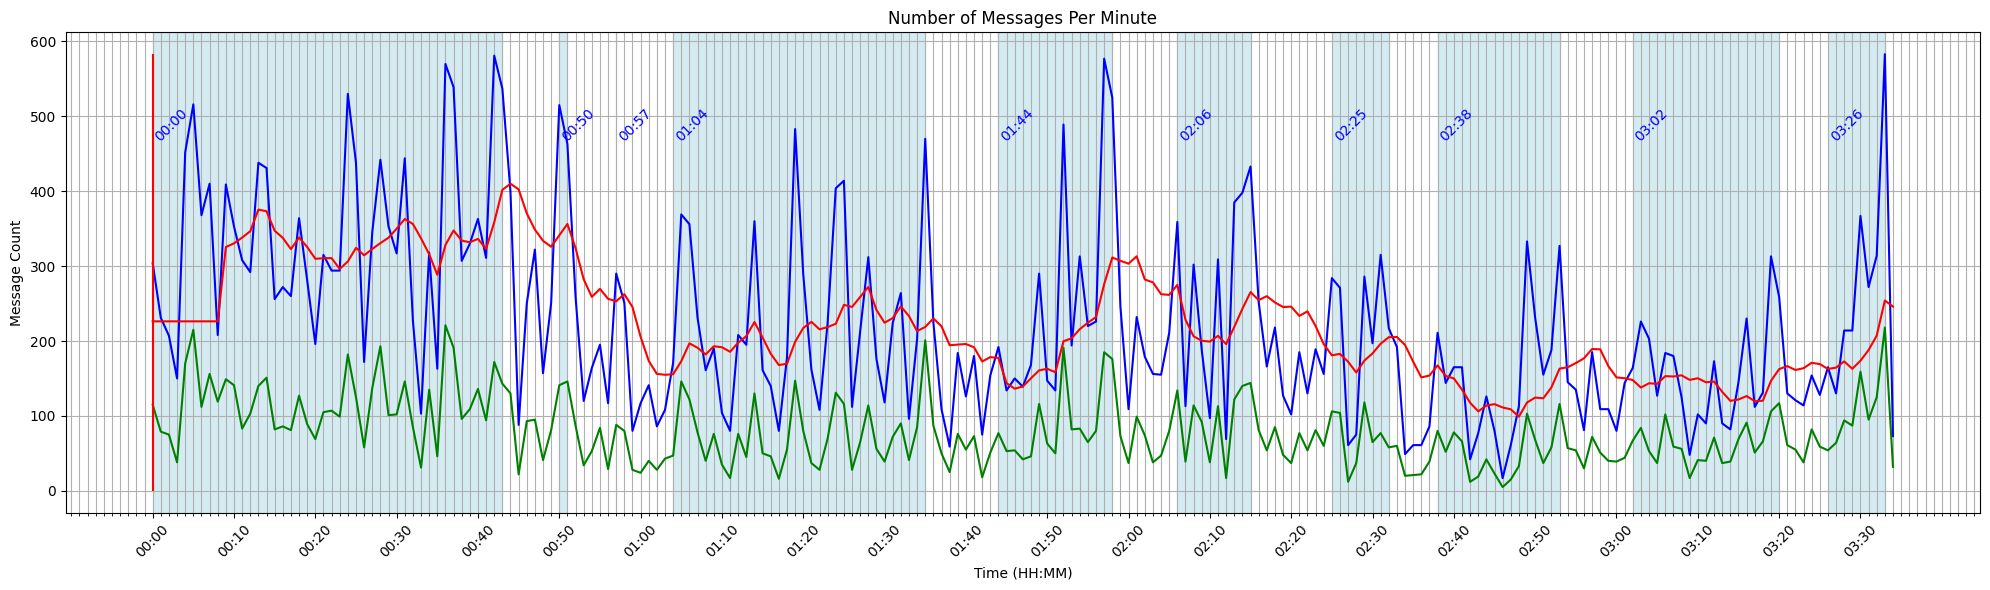

In [15]:
plt.figure(figsize=(20, 6))

plt.plot(total_messages_per_minute['time_in_minutes'], total_messages_per_minute['message_count'], label='Total Messages', color='blue')

plt.plot(member_messages_per_minute['time_in_minutes'], member_messages_per_minute['message_count'], label='Member Messages', color='green')

plt.plot(moving_average['time_in_minutes'], moving_average['message_count'], label="Moving Average", color='red')

for start, end in merged_intervals:
    plt.axvspan(start, end, color='lightblue', alpha=0.5)
    plt.text(start, total_messages_per_minute['message_count'].max() * 0.8, minutes_to_hhmm(start), color='blue', fontsize=10, rotation=45)

plt.vlines(0, ymin=0, ymax=total_messages_per_minute['message_count'].max(), colors='red')

plt.xticks(ticks=minutes_10min, labels=time_labels_10min, rotation=45)
plt.gca().xaxis.set_minor_locator(MultipleLocator(1))
plt.xlabel('Time (HH:MM)')
plt.ylabel('Message Count')
plt.title('Number of Messages Per Minute')

plt.grid(True, which='both')
plt.tight_layout()
plt.savefig(env_.chat_timeline_path)
plt.show()

In [16]:
with open(env_.cleaned_list_path, 'r', encoding='utf8') as f:
    filter_words = [word.strip() for word in f.readlines()]
pattern = re.compile(r'\b(' + '|'.join(filter_words) +
                    r')\b|(:[^:]+:)|(\(.*?\)[^\w\s]*)|(^\@\w+\s$)|(^\?+$)|\p{S}|\p{P}|\p{C}', re.IGNORECASE)
df['cleaned_message'] = df['message'].apply(
    lambda x:  recursive_replace(pattern, '', x)).replace('', np.nan)

df = df.dropna(subset='cleaned_message')
df['cleaned_message'].nunique()

20266

In [17]:
from summary import Summary

df_filtered = df[df['cleaned_message'].str.len() > 0]

summary = Summary(env_, '\n'.join(df_filtered[['message']].to_numpy().flatten())).getContent()
summary

'**Overall Summary of Discussion:**\nThe YouTube chat was a vibrant celebration of Gigi\'s performance as Gonathan G during the ENreco roleplay event. Viewers expressed their admiration for the storytelling, character development, and emotional engagement throughout the series, particularly highlighting the interactions involving Gonathan, Ame, and other characters. The chat was filled with excitement about future chapters, character arcs, and a desire for more collaborative content. They discussed the impact of the character arcs, including the humorous aspects and bittersweet moments, showcasing a strong emotional connection to the narrative.\n\n**Situation:**\nThe sentiment in the chat was overwhelmingly positive, filled with enthusiasm and admiration. As Gigi shared insights about the roleplay experience and the character of Gonathan, the chat overflowed with praise, laughter, and expressions of emotional attachment. Gigi was actively engaging with the audience, reflecting on the i

In [18]:
num_intervals = len(merged_intervals)
cols = 3
rows = math.ceil(num_intervals / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, 3 * rows))

index = -1
for i, time_range in enumerate(merged_intervals):
    try:
        index += 1
        start = time_range[0] * 60
        end = time_range[1] * 60
        start_label = minutes_to_hhmm(time_range[0])
        end_label = minutes_to_hhmm(time_range[1])

        df_filtered = df[(df['time_in_seconds'] >= start) & (df['time_in_seconds'] <= end) & (df['cleaned_message'].str.len() > 0)]

        word_freq = get_word_freq(df_filtered['cleaned_message'])
        word_path = os.path.join(env_.data_path, f'{start_label}_{end_label}'.replace(':', '-'))
        wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=50, min_word_length=3).generate_from_frequencies(word_freq)

        df_filtered[['time_in_seconds', 'message']].to_csv(f'{word_path}_chat.csv', encoding='utf8', index=False)
        word_freq.to_csv(f'{word_path}_wfreq.csv', encoding='utf8', header=False)

        ax = axes[index // cols][index % cols] if rows > 1 else axes[index % cols]

        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")

        ax.set_title(f'{start_label} - {end_label}', fontsize=14)
    except Exception as e:
        index -= 1
        continue

for j in range(index + 1, rows * cols):
    fig.delaxes(axes[j // cols][j % cols] if rows > 1 else axes[j % cols])

plt.tight_layout()
plt.savefig(env_.chat_wordcloud_path)
plt.show()

<Figure size 1800x1200 with 0 Axes>

In [22]:
font_name = os.getenv('DEFAULT_FONT_NAME')
font_path = f"{os.getenv('DEFAULT_FONT_PATH')}/{font_name}/{os.getenv('DEFAULT_FONT_FILENAME')}"
pdfmetrics.registerFont(TTFont(font_name, font_path, 'utf8'))

c = canvas.Canvas(os.path.join(env_.data_path, 'report.pdf'), pagesize=A4)

width, height = A4
cursor = height
margin = 8
available_width = width - 2 * margin

c.setFont(font_name, 16)

cursor = height - 32

text_width = c.stringWidth(env_.video_title)
x_position = (available_width - text_width) / 2  # 計算置中位置

c.drawString(x_position, cursor, env_.video_title)

c.setFont(font_name, 12)
cursor = cursor - 17
text_width = c.stringWidth(env_.video_liver)
x_position = (available_width - text_width)
c.drawString(x_position, cursor, env_.video_liver)

cursor = cursor - 10
cursor = draw_markdown_to_pdf(c, summary, cursor, margin, width, height, font_name)

image = ImageReader(env_.chat_timeline_path)
img_width, img_height = image.getSize()

# 計算圖片縮放比例，保持等比例縮放
scale_factor = available_width / img_width
scaled_width = available_width
scaled_height = img_height * scale_factor

# 如果圖片的高度超過頁面，則根據頁面的高度進行縮放
if scaled_height > height:
    scale_factor = height / img_height
    scaled_height = height
    scaled_width = img_width * scale_factor

# 計算圖片位置（居中顯示圖片）
x_position = margin  # 左右保持 8px 的空格
cursor = y_position = cursor - scaled_height - 10

# 插入圖片
c.drawImage(image, x_position, y_position, width=scaled_width, height=scaled_height)

image = ImageReader(env_.chat_wordcloud_path)
img_width, img_height = image.getSize()

# 計算圖片縮放比例，保持等比例縮放
scale_factor = available_width / img_width
scaled_width = available_width
scaled_height = img_height * scale_factor

# 如果圖片的高度超過頁面，則根據頁面的高度進行縮放
if scaled_height > height:
    scale_factor = height / img_height
    scaled_height = height
    scaled_width = img_width * scale_factor

# 計算圖片位置（居中顯示圖片）
x_position = margin  # 左右保持 8px 的空格
cursor = y_position = cursor - scaled_height - 10

# 插入圖片
c.drawImage(image, x_position, y_position, width=scaled_width, height=scaled_height)

c.setFont(font_name, 12)
with open(os.path.join(env_.data_path, 'watching_urls.log'), 'r', encoding='utf8') as f:
    for url in f.readlines():
        cursor = y_position = cursor - 20

        # 繪製連結文字
        c.drawString(x_position, y_position, url.strip())

        # 為該文字添加 URL
        # 計算文字寬度，確定連結區域
        text_width = c.stringWidth(url, font_name, 12)
        c.linkURL(url.strip(), (x_position, y_position, x_position + text_width, y_position + 12))

c.save()
